In [189]:
# Defining dependencies
import pandas as pd
import numpy as np
import math
import requests
import json
import os
from matplotlib import pyplot as plt
import seaborn as sns

In [190]:
# Loading csv into a dataframe which contains regular season game data starting season 20152016 thru 20192020
df = pd.read_csv(r'C:\Users\chait\OneDrive\Documents\School\IFT_6758\2.Project\Milestone2_Draft\Delivery\Chaitanya\branch_chaitu\ift6758-project-template-main\notebooks\tidy_df.csv')

In [191]:
# Imputing empty net data in existing dataframe

df['empty_net'] = df['empty_net'].replace(np.nan,0)
df['empty_net'] = df['empty_net'].replace(True,1)
df['empty_net'] = df['empty_net'].replace(False,0)

In [192]:
# Shot angle (in degrees) added to the dataframe

list_angle = []
for i in range(0,df.shape[0]):

    if df.attacking_team_side[i] == "right":
        if df.y_coordinates[i] == 0:
            list_angle.append(0)
        elif df.y_coordinates[i] > 0:
            list_angle.append(np.arcsin(df.y_coordinates[i]/df.distance_from_net[i])*-180/math.pi)
        else:
            list_angle.append(np.arcsin(df.y_coordinates[i]/df.distance_from_net[i])*-180/math.pi)
            
    elif df.attacking_team_side[i] == "left":
        if df.y_coordinates[i] == 0:
            list_angle.append(0)
        elif df.y_coordinates[i] > 0:
            list_angle.append(np.arcsin(df.y_coordinates[i]/df.distance_from_net[i])*180/math.pi)
        else:
            list_angle.append(np.arcsin(df.y_coordinates[i]/df.distance_from_net[i])*180/math.pi)
df['angle_from_net'] = list_angle

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379606 entries, 0 to 379605
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   game_id                    379606 non-null  int64  
 1   season                     379606 non-null  int64  
 2   season_type                379606 non-null  object 
 3   event_id                   379606 non-null  int64  
 4   home_team                  379606 non-null  object 
 5   away_team                  379606 non-null  object 
 6   home_team_side_1st_period  371926 non-null  object 
 7   attacking_team             379606 non-null  object 
 8   attacking_player           379606 non-null  object 
 9   goalie                     377850 non-null  object 
 10  period                     379606 non-null  int64  
 11  period_time                379606 non-null  object 
 12  goal_ind                   379606 non-null  int64  
 13  shot_ind                   37

In [194]:
# Dropping the rows that doesn't have X or Y coordinates

df = df[~df['distance_from_net'].isnull()] # distance was null for 17 rows
df = df[~df['angle_from_net'].isnull()] # angle was null for 18 rows

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 379585 entries, 0 to 379605
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   game_id                    379585 non-null  int64  
 1   season                     379585 non-null  int64  
 2   season_type                379585 non-null  object 
 3   event_id                   379585 non-null  int64  
 4   home_team                  379585 non-null  object 
 5   away_team                  379585 non-null  object 
 6   home_team_side_1st_period  371905 non-null  object 
 7   attacking_team             379585 non-null  object 
 8   attacking_player           379585 non-null  object 
 9   goalie                     377830 non-null  object 
 10  period                     379585 non-null  int64  
 11  period_time                379585 non-null  object 
 12  goal_ind                   379585 non-null  int64  
 13  shot_ind                   37

In [196]:
# Training (train+validation sets for model) and test sets creation

df_train = df[df['season'] != 20192020]
df_test = df[df['season'] == 20192020]

In [197]:
# mid_df.csv creation which is an input for Q3 and Q4

df_train.to_csv('mid_df.csv',index=False)

In [198]:
# test_df.csv creation which is an input for Q7

df_test.to_csv('test_df.csv',index=False)

In [199]:
# df_train_nogoals is a dataframe which has only no goal observations
df_train_nogoals = df_train[df_train['shot_ind']==1]

# df_train_goals is a dataframe which has only goal observations
df_train_goals = df_train[df_train['goal_ind']==1]

<Figure size 432x288 with 0 Axes>

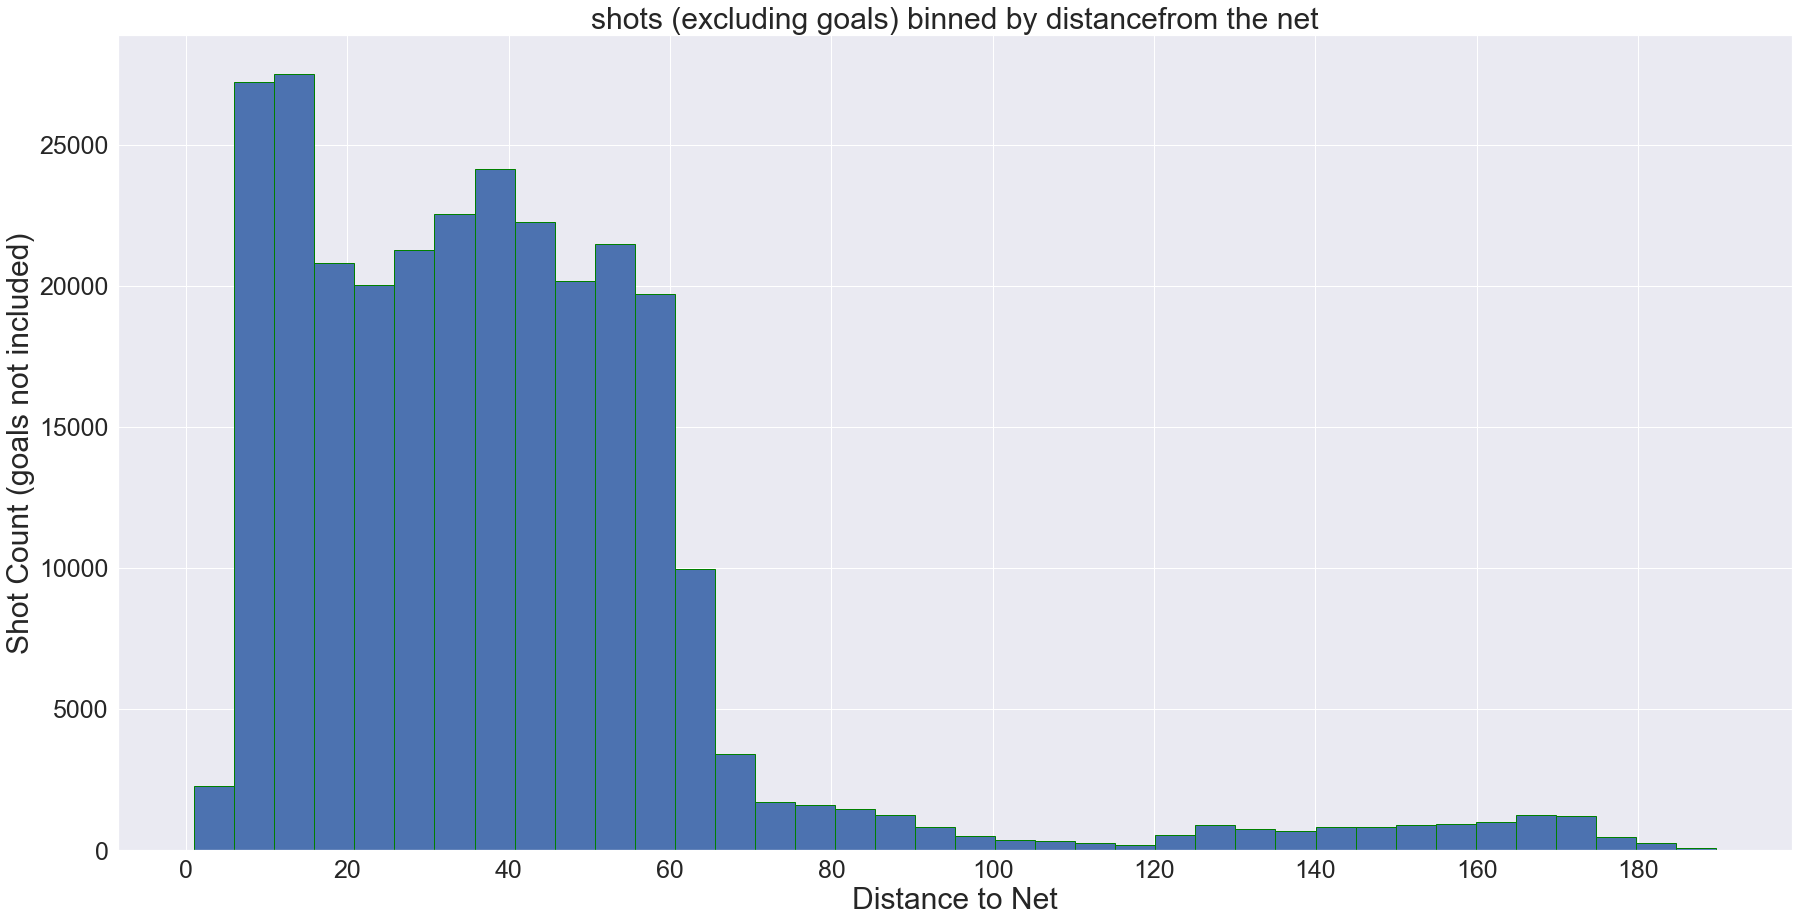

In [200]:
# Histogram of shot counts - No-goal shots binned by distance

fig = plt.figure()
fig = plt.figure(figsize=(30,15))
values = np.arange(0,df_train_nogoals['distance_from_net'].max()+5,20)
plt.hist(df_train_nogoals['distance_from_net'], edgecolor="green", bins=math.ceil((df_train_nogoals['distance_from_net'].max() - df_train_nogoals['distance_from_net'].min())/5))
plt.title("shots (excluding goals) binned by distancefrom the net",size=30)
plt.xlabel("Distance to Net",size=30)
plt.ylabel("Shot Count (goals not included)",size=30)
plt.xticks(values,size = 25)
plt.yticks(size = 25)
plt.show()
fig.savefig('Q2_1.png')

<Figure size 432x288 with 0 Axes>

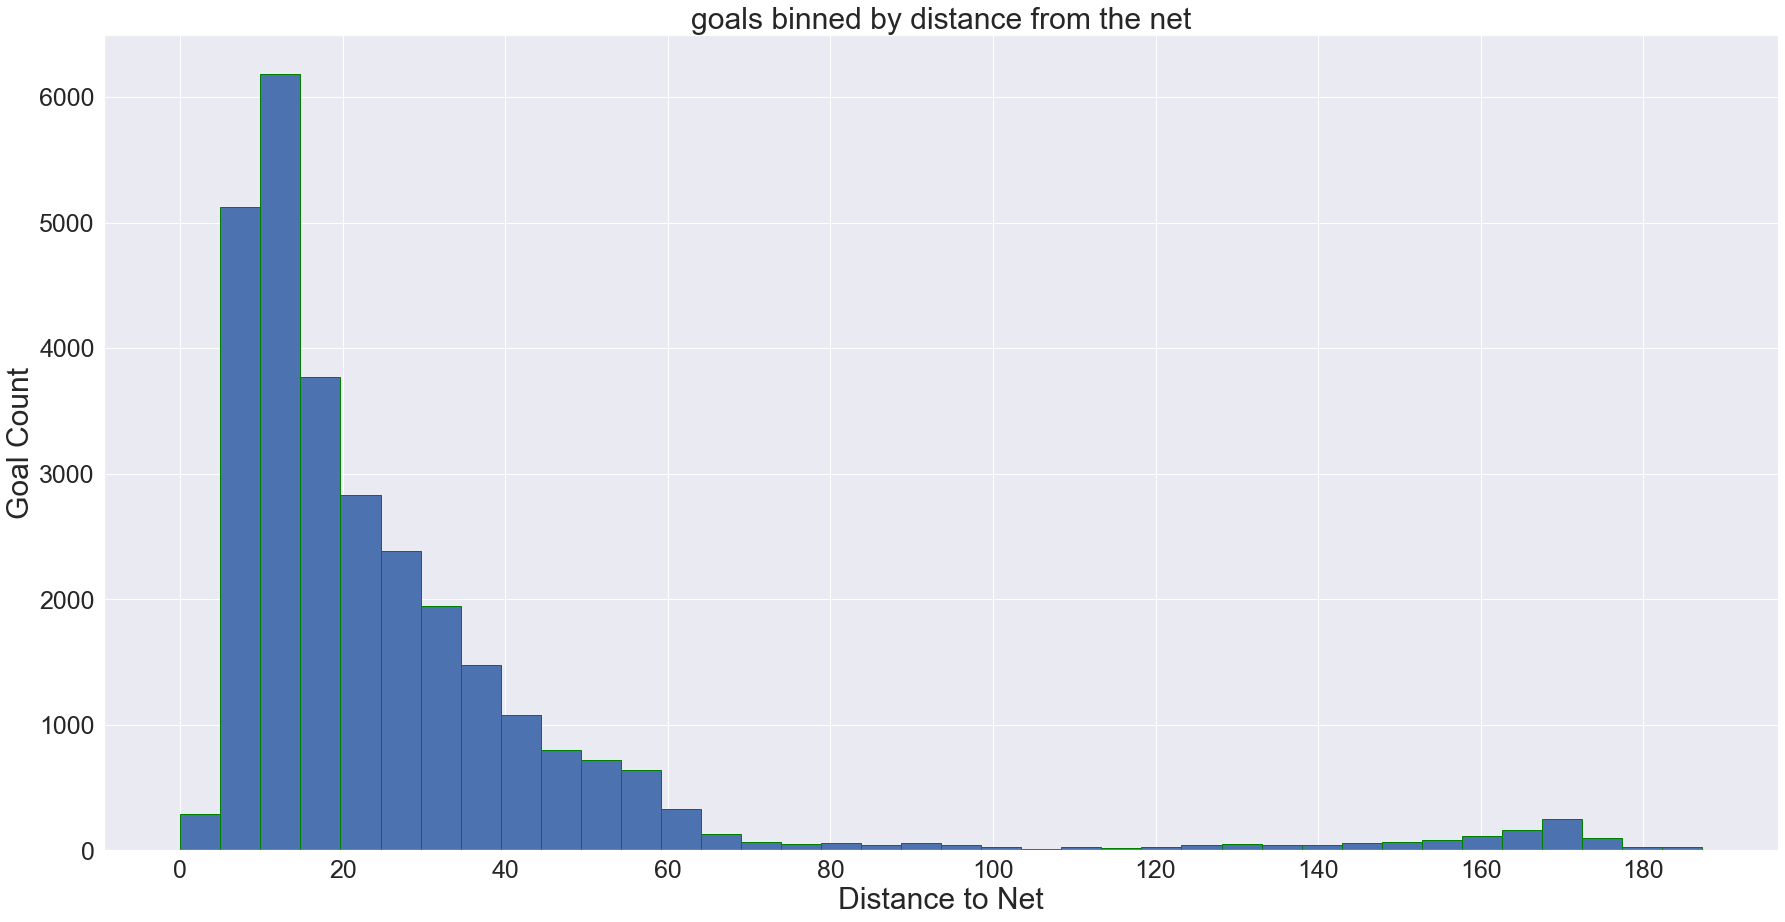

In [201]:
# Histogram of shot counts - goals binned by distance

fig = plt.figure()
fig = plt.figure(figsize=(30,15))
values = np.arange(0,df_train_goals['distance_from_net'].max()+5,20)
plt.hist(df_train_goals['distance_from_net'], edgecolor="green", bins=math.ceil((df_train_goals['distance_from_net'].max() - df_train_goals['distance_from_net'].min())/5))
plt.title("goals binned by distance from the net",size=30)
plt.xlabel("Distance to Net",size=30)
plt.ylabel("Goal Count",size=30)
plt.xticks(values,size = 25)
plt.yticks(size = 25)
plt.show()
fig.savefig('Q2_2.png')

<Figure size 432x288 with 0 Axes>

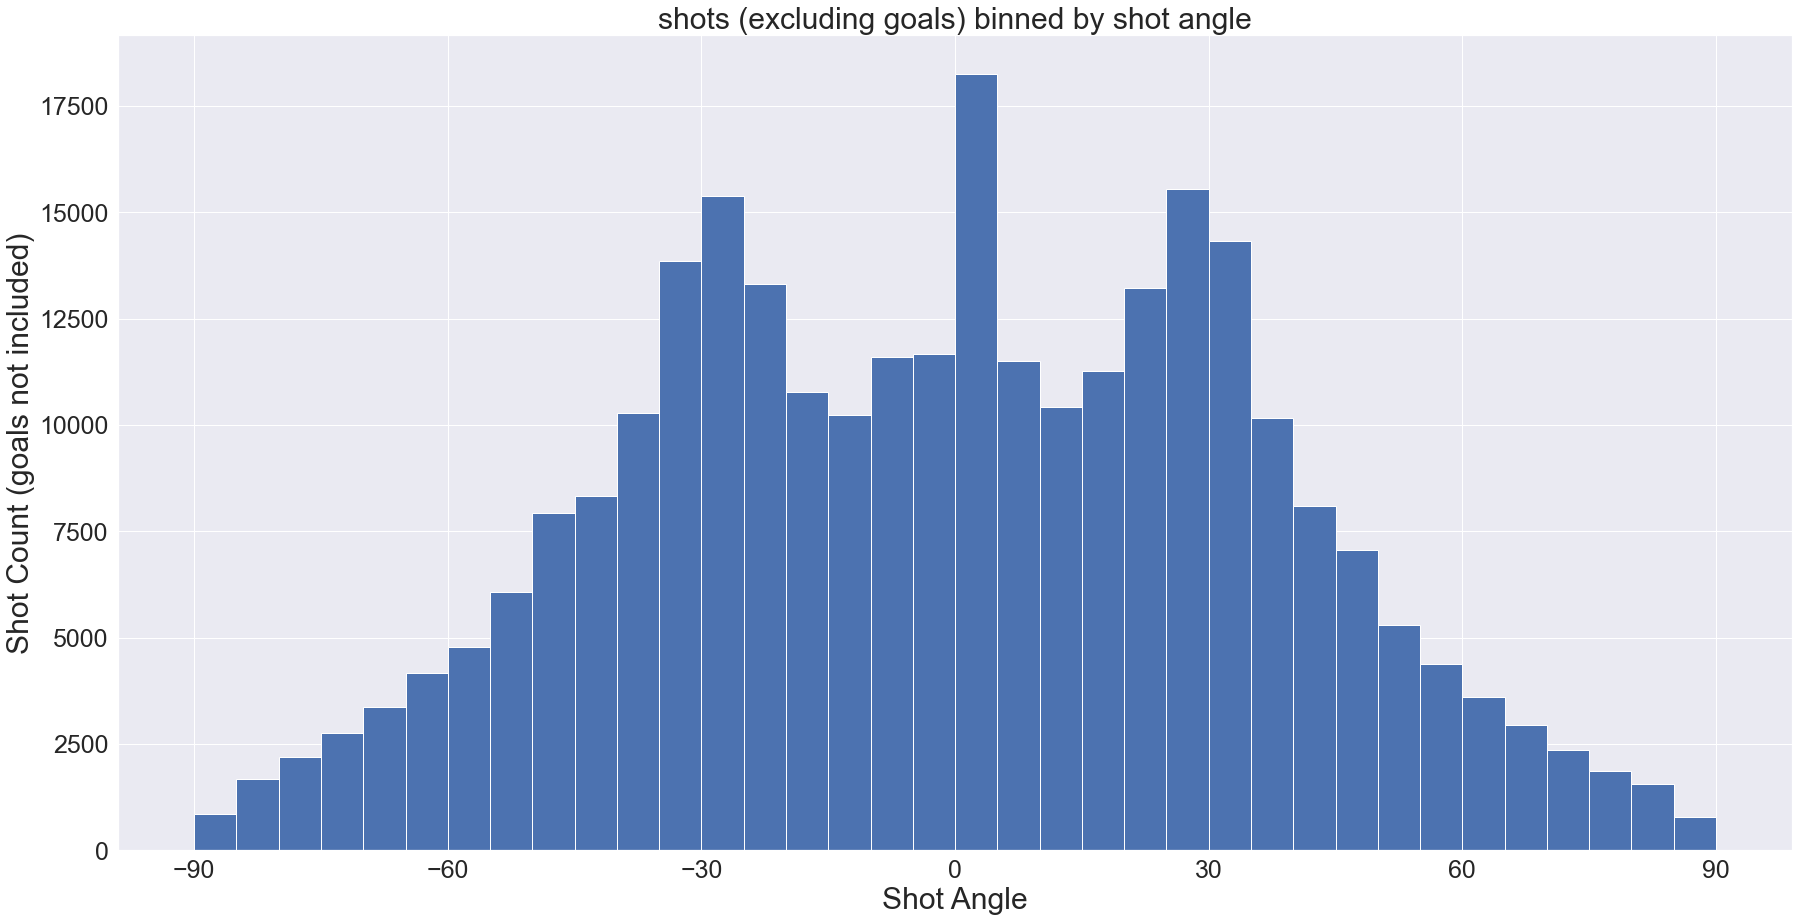

In [202]:
# Histogram of shot counts - No-goal shots binned by angle
fig = plt.figure()
fig = plt.figure(figsize=(30,15))
plt.hist(df_train_nogoals['angle_from_net'], bins=math.ceil((df_train_nogoals['angle_from_net'].max() - df_train_nogoals['angle_from_net'].min())/5))
plt.title("shots (excluding goals) binned by shot angle",size=30)
plt.xlabel("Shot Angle",size=30)
plt.ylabel("Shot Count (goals not included)",size=30)
plt.xticks(np.arange(-90,100,30),size = 25)
plt.yticks(size = 25)
plt.show()
fig.savefig('Q2_3.png')

<Figure size 432x288 with 0 Axes>

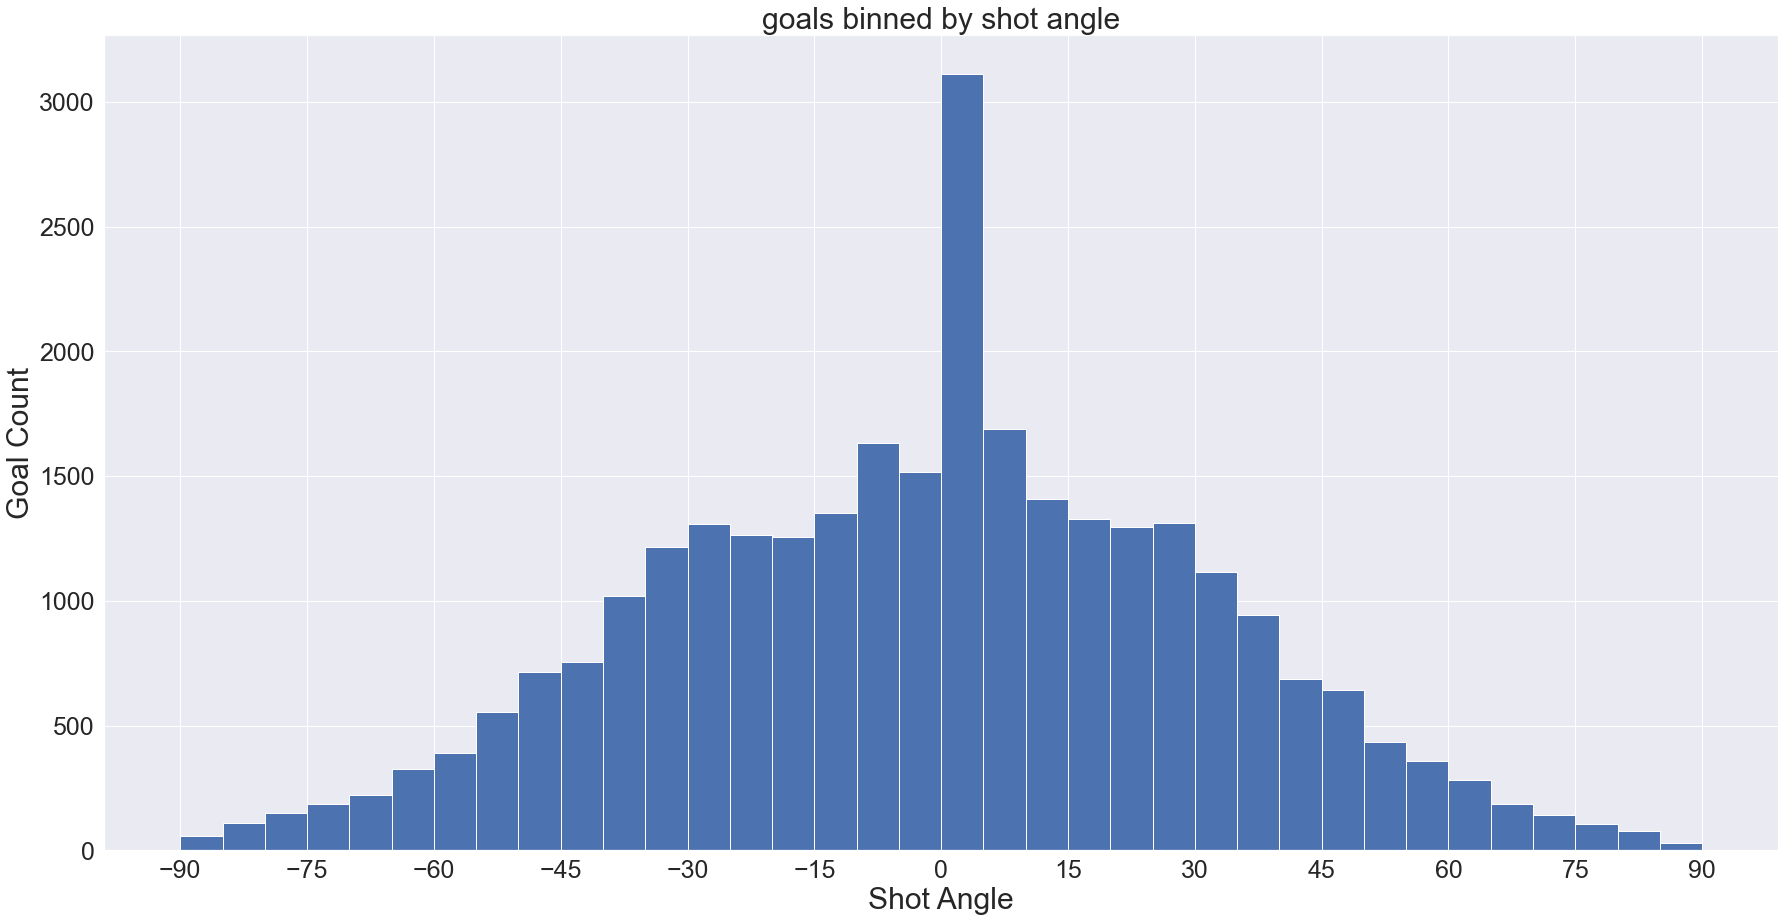

In [203]:
# Histogram of shot counts - goals binned by angle
fig = plt.figure()
fig = plt.figure(figsize=(30,15))
plt.hist(df_train_goals['angle_from_net'], bins=math.ceil((df_train_goals['angle_from_net'].max() - df_train_goals['angle_from_net'].min())/5))
plt.title("goals binned by shot angle",size=30)
plt.xlabel("Shot Angle",size=30)
plt.ylabel("Goal Count",size=30)
plt.xticks(np.arange(-90,100,15),size = 25)
plt.yticks(size = 25)
plt.show()
fig.savefig('Q2_4.png')

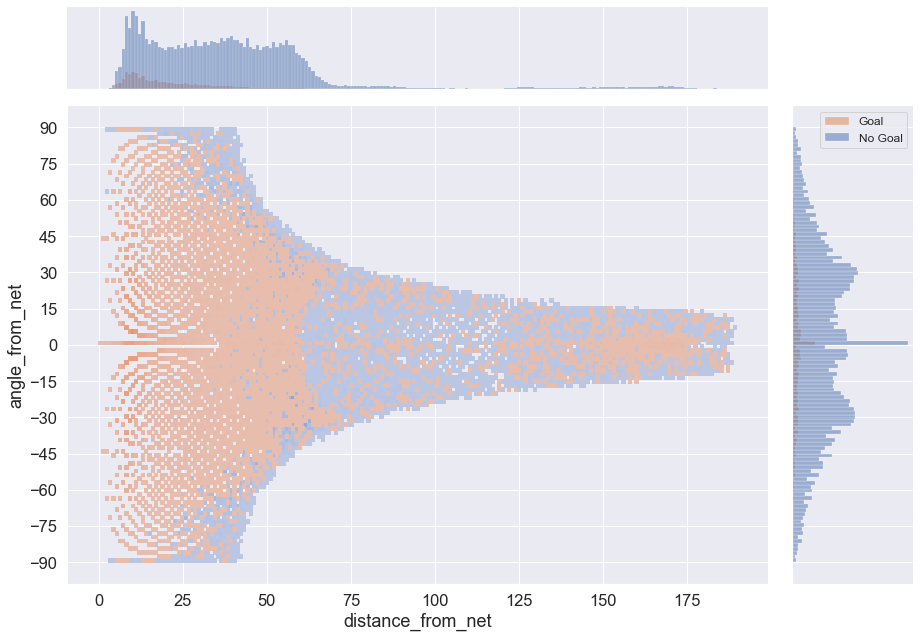

In [204]:
# Joint plot showing the relation between distance of the shot and angle of the shot
sns.set(font_scale = 1.5)
g = sns.jointplot(data=df_train, x="distance_from_net", y="angle_from_net", hue="goal_ind",legend=False, kind = "hist")
g.fig.set_figwidth(15)
g.fig.set_figheight(10)
plt.legend(labels=["Goal","No Goal"], fontsize = 12)
plt.yticks(np.arange(-90,100,15),size = 25)
values = np.arange(0,df_train['distance_from_net'].max()+5,20)
plt.xticks(values,size = 25)
plt.show(g)
g.savefig("Joint_Plot.png")

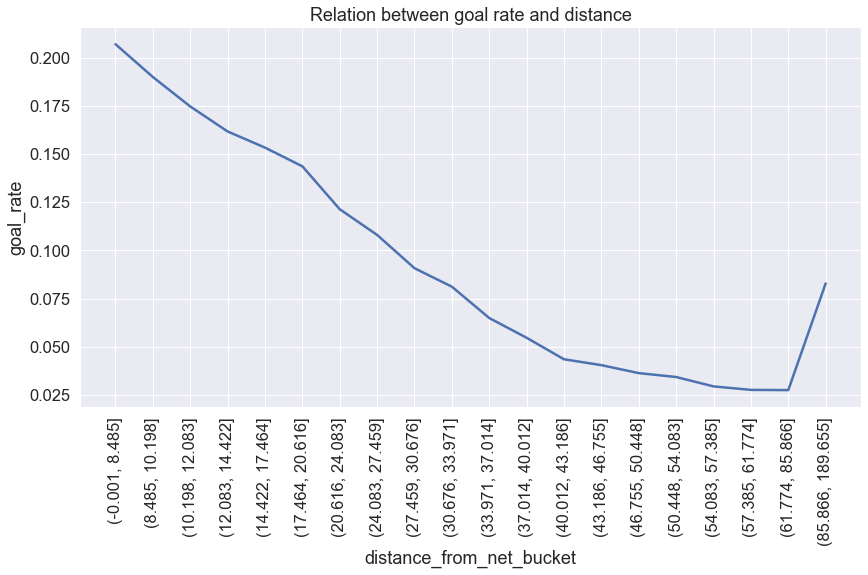

In [205]:
# Relation between goal rate and distance

df_train1 = df_train.copy()

n_buckets = 20

df_train1['distance_from_net_bucket'] = pd.qcut(df_train1['distance_from_net'], n_buckets, labels = False) +1
df_train1['angle_from_net_bucket'] = pd.qcut(df_train1['angle_from_net'], n_buckets, labels = False) +1

intervals = list(set(pd.qcut(df_train1['distance_from_net'], n_buckets)))
intervals.sort()
intervals = [str(interval) for interval in intervals]


intervals_ang = list(set(pd.qcut(df_train1['angle_from_net'], n_buckets)))
intervals_ang.sort()
intervals_ang = [str(interval_ang) for interval_ang in intervals_ang]

df_train1['shot_count'] = 1
df_train_copy = df_train1.copy()


df_train_copy1 = df_train_copy[['goal_ind','shot_count','distance_from_net_bucket']].groupby(['distance_from_net_bucket']).sum().reset_index()
df_train_copy1['goal_rate'] = df_train_copy1['goal_ind']/df_train_copy1['shot_count']

y1_max = max(df_train_copy1['goal_rate'])

fig = plt.figure(figsize = (14,7))
ax = sns.lineplot(x = 'distance_from_net_bucket', y = 'goal_rate', label='goal percentage', data = df_train_copy1, color='b', legend = False, linewidth = 2.5)
ax.set_xticks(range(1,n_buckets+1))
ax.set_xticklabels(intervals, rotation = 90)
ax.set_ylim(bottom=0, top=y1_max * 1.1)
plt.title(f"Relation between goal rate and distance")
plt.autoscale()
fig.savefig("Q2_5.png", bbox_inches = 'tight')


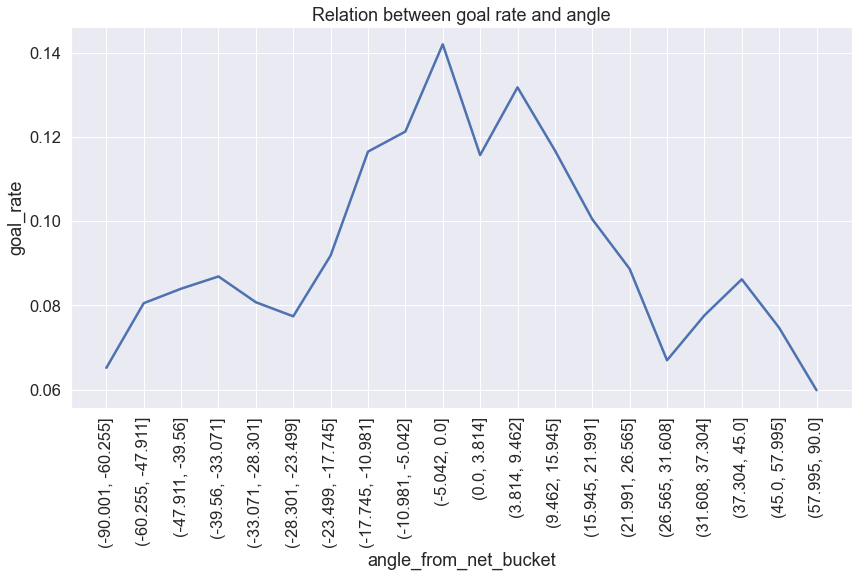

In [206]:
# Relation between goal rate and angle

df_train_copy2 = df_train_copy[['goal_ind','shot_count','angle_from_net_bucket']].groupby(['angle_from_net_bucket']).sum().reset_index()
df_train_copy2['goal_rate'] = df_train_copy2['goal_ind']/df_train_copy2['shot_count']

y2_max = max(df_train_copy2['goal_rate'])

fig = plt.figure(figsize = (14,7))
ax = sns.lineplot(x = 'angle_from_net_bucket', y = 'goal_rate', label='goal percentage', data = df_train_copy2, color='b', legend = False, linewidth = 2.5)
ax.set_xticks(range(1,n_buckets+1))
ax.set_xticklabels(intervals_ang, rotation = 90)
ax.set_ylim(bottom=0, top=y2_max * 1.1)
plt.title(f"Relation between goal rate and angle")
plt.autoscale()
fig.savefig("Q2_6.png", bbox_inches = 'tight')


In [207]:
#goals only to be binned by distance for empty net and non-empty net events

df_empty_net_goal = df_train[(df_train['empty_net']==1) & (df_train['goal_ind']==1)]
df_non_empty_net_goal = df_train[(df_train['empty_net']==0) & (df_train['goal_ind']==1)]
#print(df_empty_net_goal.shape[0], df_non_empty_net_goal.shape[0])

<Figure size 432x288 with 0 Axes>

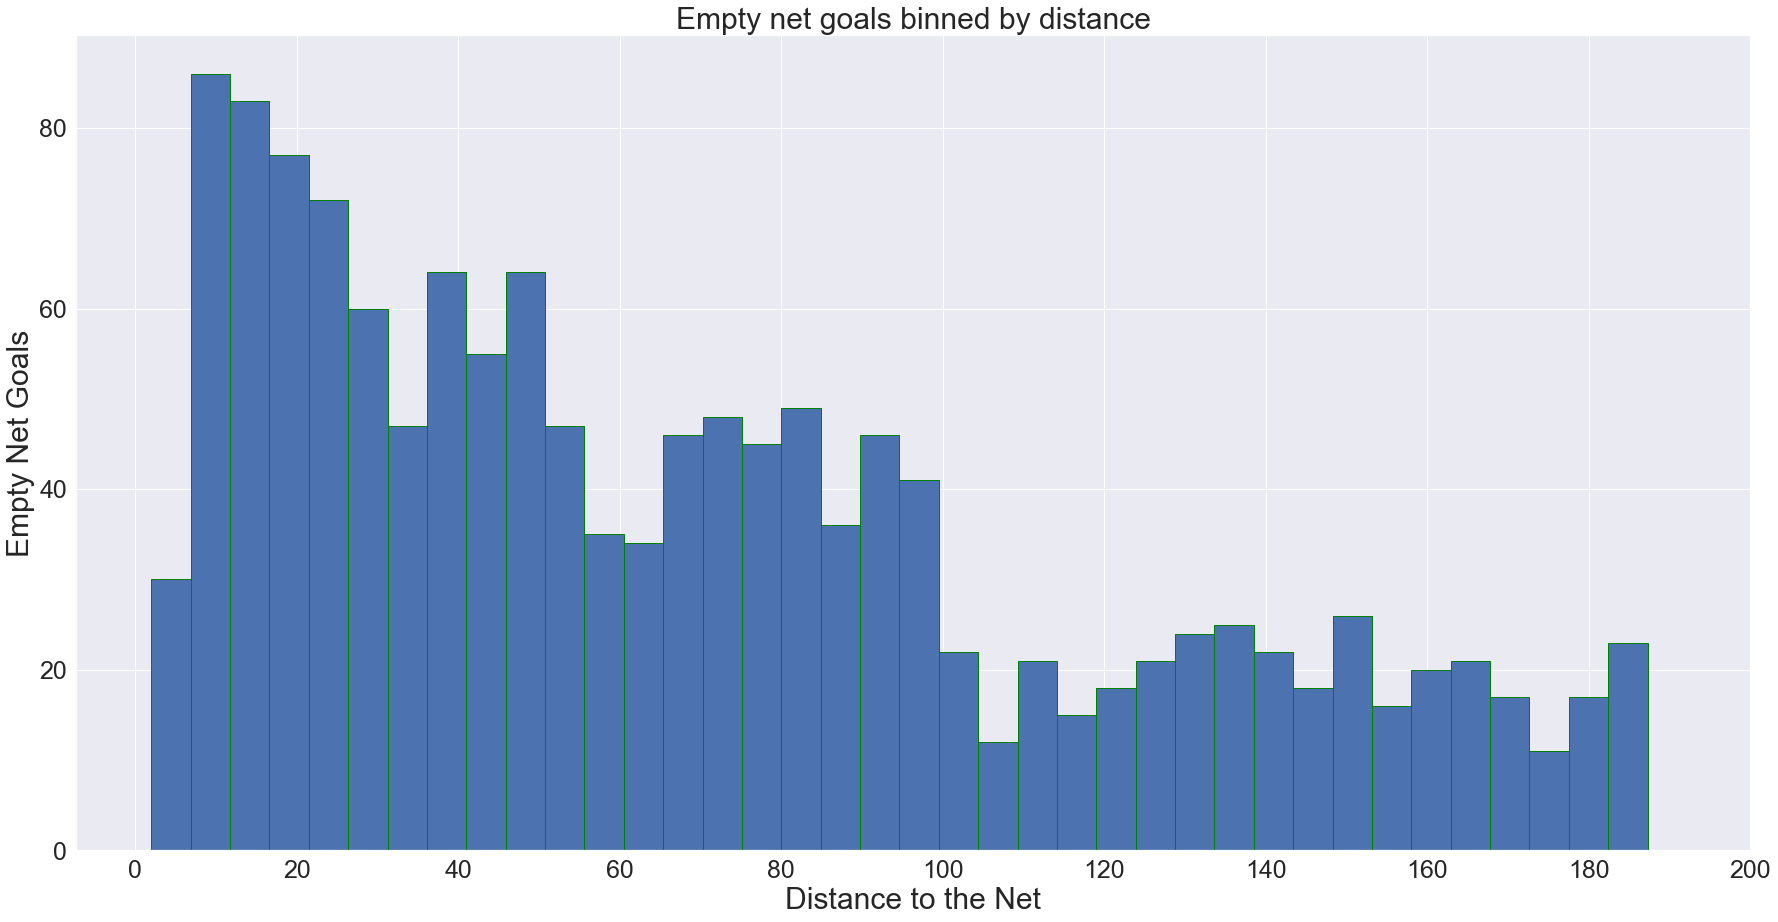

In [208]:
# Empty net goals binned by distance

fig = plt.figure()
fig = plt.figure(figsize=(30,15))
plt.hist(df_empty_net_goal['distance_from_net'], edgecolor="green", bins=math.ceil((df_empty_net_goal['distance_from_net'].max() - df_empty_net_goal['distance_from_net'].min())/5))
plt.title("Empty net goals binned by distance",size=30)
plt.xlabel("Distance to the Net",size=30)
plt.ylabel("Empty Net Goals",size=30)
values = np.arange(0,df_empty_net_goal['distance_from_net'].max()+20,20)
plt.xticks(values,size = 25)
plt.yticks(size = 25)
plt.show()
fig.savefig('Q2_7.png')



<Figure size 432x288 with 0 Axes>

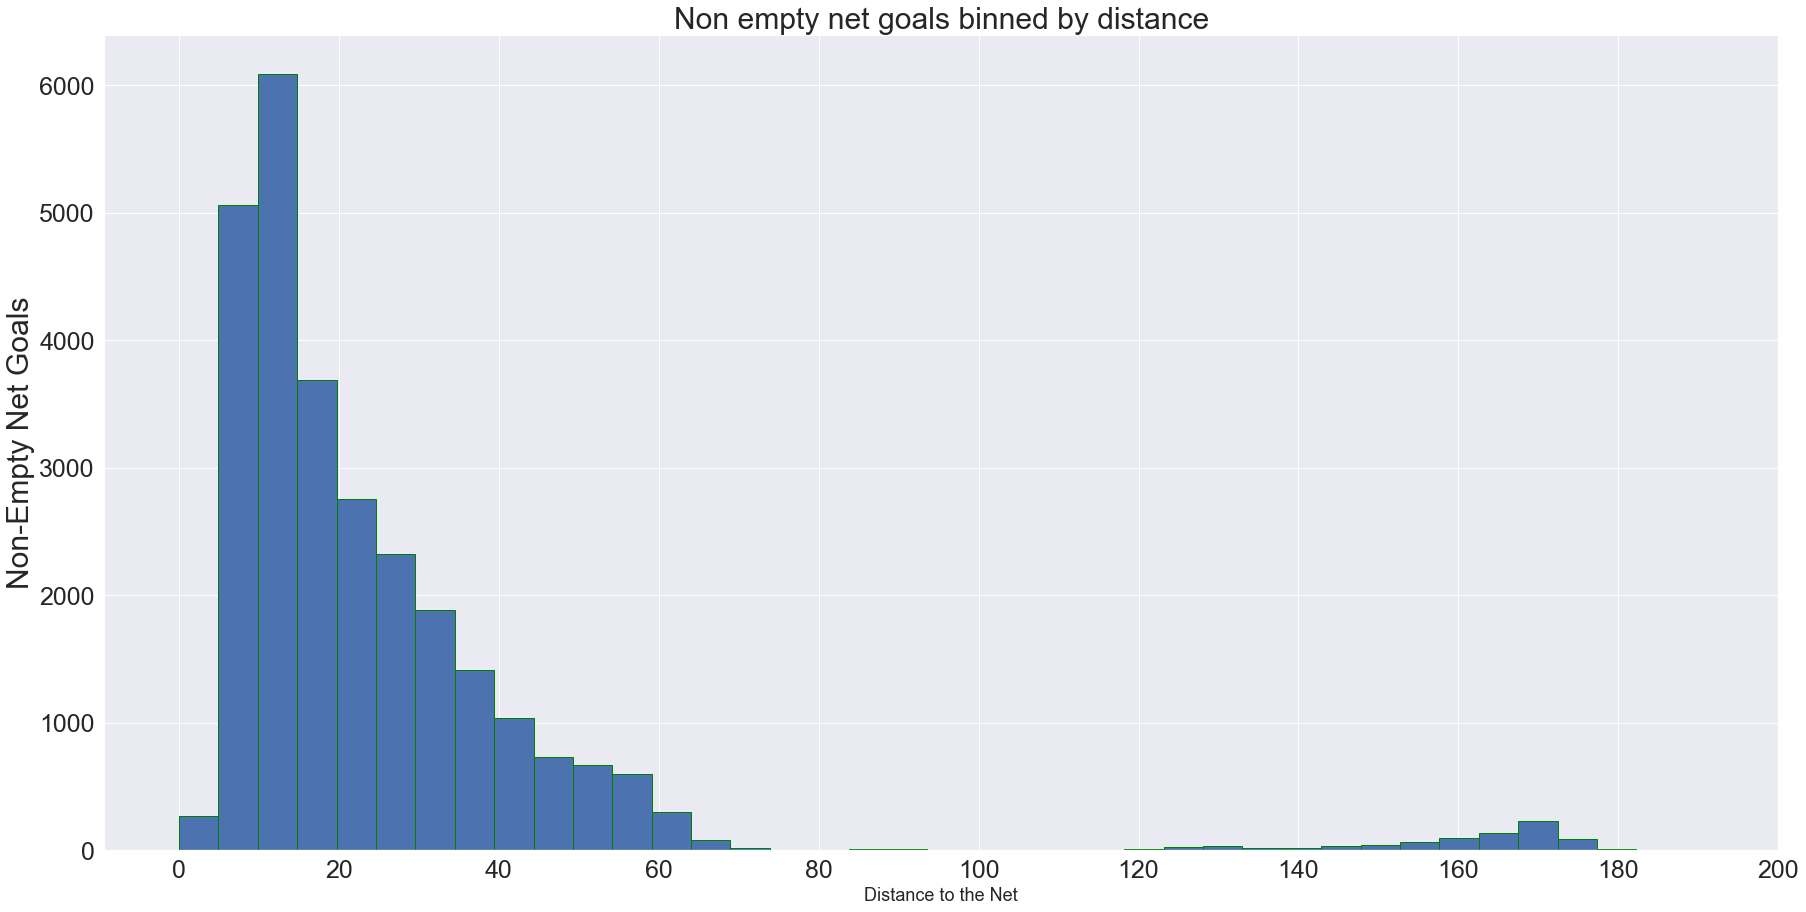

In [209]:
# Non-Empty net goals binned by distance

fig = plt.figure()
fig = plt.figure(figsize=(30,15))
plt.hist(df_non_empty_net_goal['distance_from_net'], edgecolor="green", bins=math.ceil((df_non_empty_net_goal['distance_from_net'].max() - df_non_empty_net_goal['distance_from_net'].min())/5))
plt.title("Non empty net goals binned by distance",size=30)
plt.xlabel("Distance to the Net")
plt.ylabel("Non-Empty Net Goals",size=30)
values = np.arange(0,df_non_empty_net_goal['distance_from_net'].max()+20,20)
plt.xticks(values,size = 25)
plt.yticks(size = 25)
plt.show()
fig.savefig('Q2_8.png')


# Events that have incorrect features (e.g. wrong x/y coordinates) validated by the NHL gamecenter video clips

When a goal is a non-empty net goal, it is very unlikely to be hit from farther distance. 
Hence, all the non-empty goals hit beyond a threshold distance (150 set in this case) and that are hit from behind the goal post (X = +/- 89) are examined againt the actual videos and determined that the coordinates of these shots in our are wrong



In [210]:
df_train_goals = df_train[df_train['goal_ind']==1]
df_goals_anomaly = df_train_goals[(df_train_goals['x_coordinates'].abs()>89)&(df_train_goals['distance_from_net']>=150)&(df_train_goals['empty_net']==0)]
df_goals_anomaly

,game_id,season,season_type,event_id,home_team,away_team,home_team_side_1st_period,attacking_team,attacking_player,goalie,...,shot_ind,x_coordinates,y_coordinates,shot_type,empty_net,strength,gwg,distance_from_net,attacking_team_side,angle_from_net
4192,2015020071,20152016,R,139,New York Islanders,San Jose Sharks,left,New York Islanders,Anders Lee,Alex Stalock,...,0,97.0,7.0,Backhand,0,Power Play,False,186.131674,right,-2.155276
9678,2015020163,20152016,R,315,Edmonton Oilers,Calgary Flames,left,Calgary Flames,Michael Frolik,Cam Talbot,...,0,93.0,26.0,Wrist Shot,0,Even,True,183.847763,right,-8.130102
15508,2015020261,20152016,R,240,New York Islanders,Arizona Coyotes,left,New York Islanders,John Tavares,Anders Lindback,...,0,-92.0,10.0,Wrist Shot,0,Even,True,181.276033,left,3.162298
22723,2015020383,20152016,R,134,Columbus Blue Jackets,Florida Panthers,left,Florida Panthers,Vincent Trocheck,Sergei Bobrovsky,...,0,-92.0,-20.0,Deflected,0,Even,False,182.101620,left,-6.305446
104738,2016020510,20162017,R,167,Florida Panthers,Detroit Red Wings,right,Florida Panthers,Derek MacKenzie,Jared Coreau,...,0,-97.0,21.0,Slap Shot,0,Even,False,187.181730,left,6.441600
